### Imports

In [3]:
from typing import Tuple, List

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from PIL import Image

import matplotlib.pyplot as plt

import random


import pandas as pd
import numpy as np

from dl.util import generate_preprocess_transformer, preprocess, undo_preprocessing

random.seed(420)
np.random.seed(420)

from model import ConvAutoencoderDenoiser

import os

### Set Variables

In [4]:
# Folders containing the clean and dirty images
path_clean: str = "../dataset/pairs/clean/"
path_dirty: str = "../dataset/pairs/dirty/"
assert os.path.exists(path_clean)
assert os.path.exists(path_dirty)

# Index to map the clean images to the dirty images
index_file: str = "../dataset/pairs/clean_dirty_index.csv"
assert os.path.isfile(index_file)
assert index_file[-3:] == "csv"

# Size of the final output image (DinA4 with a DPI of 300 is 3508x2480)
target_size: Tuple[int, int] = (3508, 2480)

# Train-, Test- and Validation-Set Sizes
train_test_val: Tuple[float, float, float] = (0.9, 0.05, 0.05)
assert 1.0 == round(sum(train_test_val), 2)

# Number of clean images -> determines dataset size
# set to `None` for full DS, `int` for explicit number and `float` < 0 for  
training_subset_size: [float, int, None] = 0.01 
assert 0 < training_subset_size <= 1 if isinstance(training_subset_size, float) else True

num_epochs: int = 10

# Variables for saving images & models weights
image_path: str = "images/baseline/"
model_path: str = "save/baseline/"
save_prefix: str = ""
assert os.path.exists(image_path)
assert os.path.exists(model_path)

# Load the Data Index

Here, we load the previously generated index file (containing two columns file_clean, file_dirty) 
that maps the input data (files dirty) to the desired data (files clean) 

In [5]:
df_clean_dirty = pd.read_csv(index_file).set_index("file_clean").sort_index()
df_clean = pd.Series(df_clean_dirty.index.unique())

df_clean_dirty.head()

,file_dirty
file_clean,
Bach_AveMaria_0.png,Bach_AveMaria_0Hole_0.png
Bach_AveMaria_0.png,Bach_AveMaria_0CharDeg_0.png
Bach_AveMaria_0.png,Bach_AveMaria_0Blur_Complete_0.png
Bach_AveMaria_0.png,Bach_AveMaria_0Bleed_0.png
Bach_AveMaria_1.png,Bach_AveMaria_1Blur_Complete_0.png


In [6]:
# Testing: Do the files exist

for file_clean in df_clean:
    assert os.path.isfile(f"{path_clean}{file_clean}")
    
    files_dirty = df_clean_dirty.loc[file_clean]["file_dirty"]
    
    assert len(files_dirty) > 0
    
    for file_dirty in files_dirty.values:
        assert os.path.isfile(f"{path_dirty}{file_dirty}")

## Visualize the degeneration

Now we check how the degenerations (Created by [DocCreator](https://doc-creator.labri.fr/)) look like 

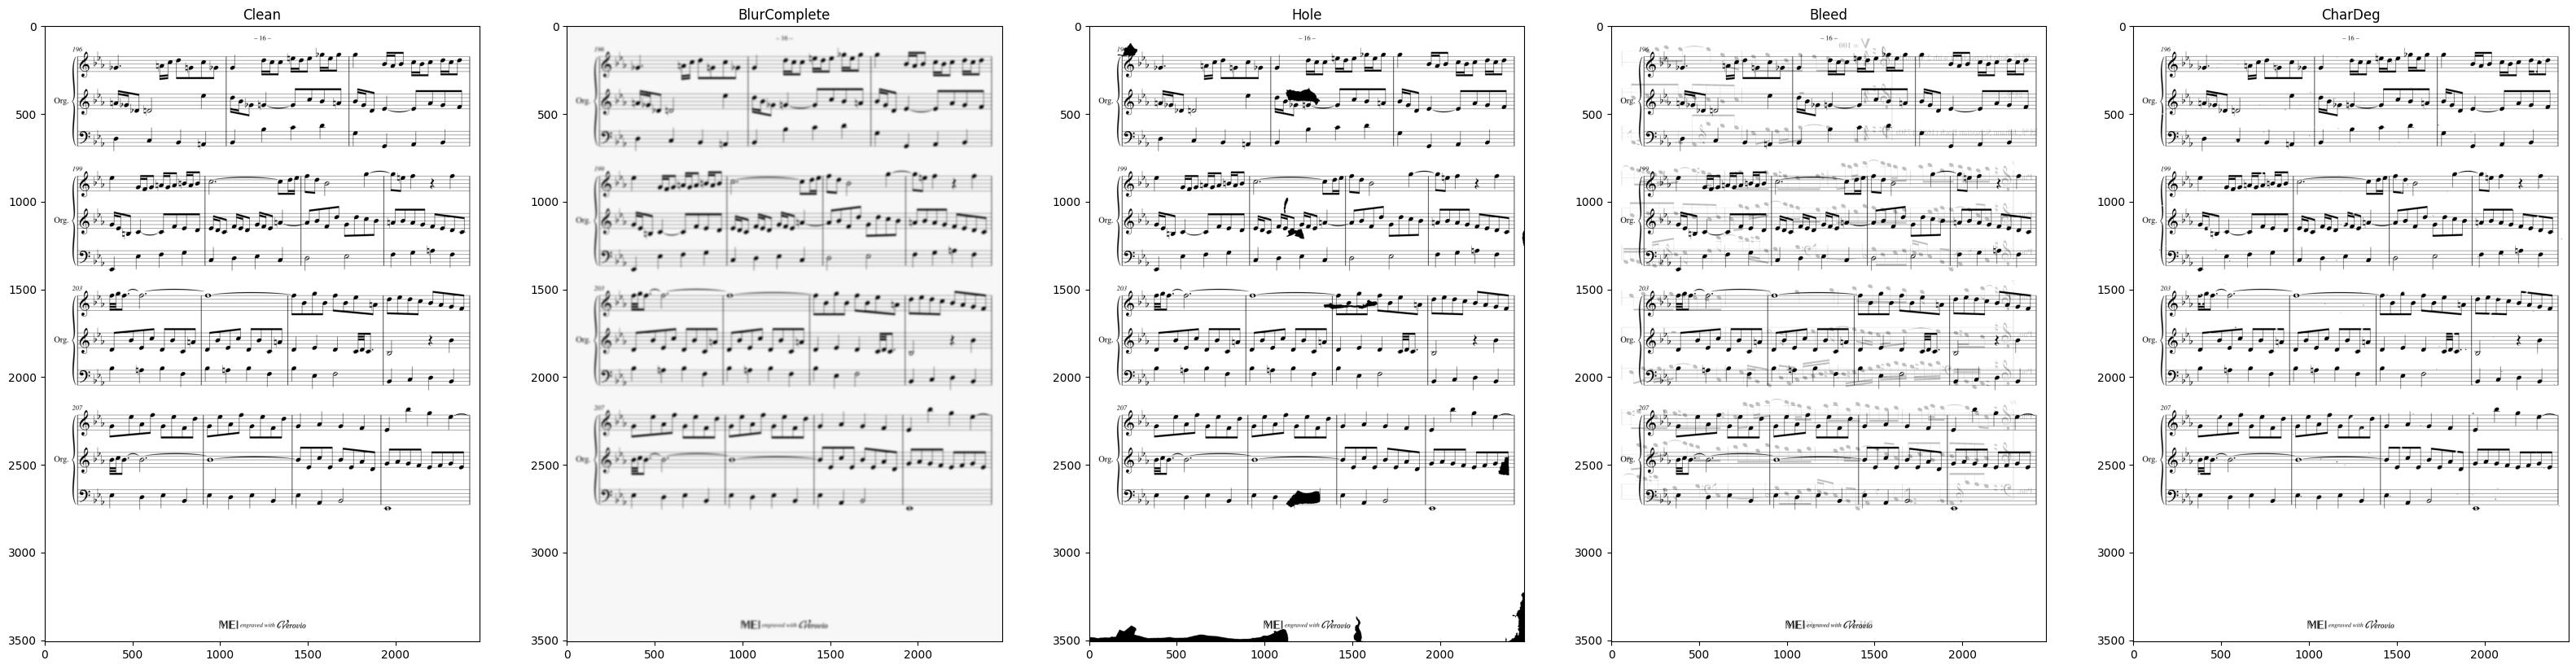

In [7]:
images = df_clean_dirty.loc[df_clean_dirty.index[random.randint(0, len(df_clean_dirty.index))]]
image_clean = images.index[0]
images_dirty = [image[0] for image in images.values]

fig, axs = plt.subplots(1, len(images) + 1, figsize=(40, 10))
axs[0].imshow(Image.open(f"{path_clean}/{image_clean}").convert('RGB'))
axs[0].set_title("Clean")

for i, image_dirty in enumerate(images_dirty):
    axs[i+1].imshow(Image.open(f"{path_dirty}/{image_dirty}").convert('RGB'))
    title = image_dirty.replace(image_clean.replace(".png", ""), "").replace("_0.png", "").replace("_", "")
    axs[i+1].set_title(title)
    
plt.savefig(f"{image_path}{save_prefix}degeneration.png")
plt.show()

# Building train, test and validation set

First we create a subset (if `training_subset_size` is set) for testing. 
Furthermore, we shuffle the data. 

In [8]:
if training_subset_size is not None:
    full_size = len(df_clean)
    subset_size = int(full_size * training_subset_size) if training_subset_size < 1 else training_subset_size
    df_clean_subset = df_clean.sample(frac=1).sample(subset_size)
    print(f"New number of clean images: {subset_size}/{full_size} ({round(subset_size*100/full_size, 2)}%)")
else:
    df_clean_subset = df_clean.sample(frac=1) # shuffle

df_clean_subset.head()

New number of clean images: 368/36802 (1.0%)


18964    Mozart_Piano_Sonatas_Piano_Sonata_n01_K279_23.png
15187                 Clementi_sonatina_op36_n6_2mov_3.png
23883       Tchaikovsky_Lake_Of_The_Swans_Act_1_1mov_2.png
29242                                  generated_275_6.png
31160                                generated_452_134.png
Name: file_clean, dtype: object

Then we apply the train, test and validation limits according to the values from `train_test_val`.

To create DataLoaders containing the filenames of the training images. This is necessary since we train with big images and a large dataset. Therefore, it doesn't fit into memory. 

In [9]:
limits = [int(limit * len(df_clean_subset)) for limit in train_test_val]

train_dataset = df_clean_subset[:limits[0]]
test_dataset = df_clean_subset[limits[0]:limits[0] + limits[1]]
valid_dataset = df_clean_subset[limits[0] + limits[1]:]

train_dataset = pd.DataFrame(train_dataset)\
    .merge(df_clean_dirty, left_on="file_clean", right_index=True).values.tolist()

test_dataset = pd.DataFrame(test_dataset)\
    .merge(df_clean_dirty, left_on="file_clean", right_index=True).values.tolist()

valid_dataset = pd.DataFrame(valid_dataset)\
    .merge(df_clean_dirty, left_on="file_clean", right_index=True).values.tolist()

print(f"New Sizes: train {len(train_dataset)} images, test {len(test_dataset)} images, validation {len(valid_dataset)} images")

New Sizes: train 1324 images, test 72 images, validation 76 images


In [10]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True)

# Train the model

First, we load the model and set the optimizer and the loss function. 

In [11]:
model = ConvAutoencoderDenoiser(target_size)

if torch.cuda.is_available():
    print('🚀 Cuda Available. Training on GPU 🤟')
    model = model.cuda()
else:
	print('❌ CUDA not available. Training on CPU 👎')

# defining the loss function
criterion = nn.MSELoss()

# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

🚀 Cuda Available. Training on GPU 🤟


Furthermore, need functions to transform the images into normalized tensors. 
In order to keep the VRAM usage comparatively low, we halve the size of the input images, since, they are upscaled within the model. 

In [12]:
transform_dirty = generate_preprocess_transformer((target_size[0] // 2, target_size[1] // 2))
transform_clean = generate_preprocess_transformer(target_size)

Now we start the actual training. 

In [13]:
min_valid_loss: float = np.Inf

training_losses: List[float] = []
validation_losses: List[float] = []

for epoch in range(num_epochs):
    print(f'\nEpoch: {epoch+1}/{num_epochs}')
    
    training_loss: float = 0.0
    
    for i, (filenames_clean, filenames_dirty) in enumerate(train_loader):
        print(f"\rTrain {round(i/len(train_loader), 4) : 4f}", end="")
        
        # Load the images from the file names and transform them into tensors using the previously created transformers
        try:
            images_clean = torch.stack([preprocess(path_clean, ip, transform_clean) for ip in filenames_clean])
            images_dirty = torch.stack([preprocess(path_dirty, ib, transform_dirty) for ib in filenames_dirty])
        except Exception as e:
            print(f"Problem with {filenames_clean}, {filenames_dirty}: {str(e)}\n\n")
            continue    
        
        if torch.cuda.is_available():
            images_clean, images_dirty = images_clean.cuda(), images_dirty.cuda()
        
        optimizer.zero_grad()
            
        outputs = model(images_dirty)
        
        loss = criterion(outputs, images_clean)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
    
    training_loss = training_loss / len(train_loader)
    training_losses.append(training_loss)
    
    # Validating
    with torch.no_grad():
        valid_loss = 0
        
        for i, (filenames_clean, filenames_dirty) in enumerate(valid_loader):
            print(f"\rValid {round(i/len(valid_loader), 4) : 4f}", end="")
            
            try:
                images_clean = torch.stack([preprocess(path_clean, ip, transform_clean) for ip in filenames_clean])
                images_dirty = torch.stack([preprocess(path_dirty, ib, transform_dirty) for ib in filenames_dirty])
            except Exception as e:
                print(f"Problem with {filenames_clean}, {filenames_dirty}: {str(e)}\n\n")
                continue
            
            if torch.cuda.is_available():
                images_dirty, images_clean = images_dirty.cuda(), images_clean.cuda()
                
            outputs = model(images_dirty)
            loss = criterion(outputs, images_clean)
            
            valid_loss += loss.item()
        
        valid_loss = valid_loss / len(valid_loader)
        validation_losses.append(valid_loss)    
        
        save_file = f"{model_path}{save_prefix}model_{epoch + 1}.pt"
        torch.save(model.state_dict(), save_file)
        
        # Compare with previous epochs 
        if valid_loss < min_valid_loss:
            print(f'\nLoss Decreased... ({min_valid_loss:.3f} -> {valid_loss:.3f})')
            print("Best Model so far: ", save_file)
            best_model = save_file
            min_valid_loss = valid_loss


Epoch: 1/10
Valid  0.973700
Loss Decreased... (inf -> 0.075)
Best Model so far:  save/baseline/model_1.pt

Epoch: 2/10
Valid  0.973700
Loss Decreased... (0.075 -> 0.061)
Best Model so far:  save/baseline/model_2.pt

Epoch: 3/10
Valid  0.973700
Loss Decreased... (0.061 -> 0.058)
Best Model so far:  save/baseline/model_3.pt

Epoch: 4/10
Valid  0.973700
Loss Decreased... (0.058 -> 0.058)
Best Model so far:  save/baseline/model_4.pt

Epoch: 5/10
Valid  0.973700
Epoch: 6/10
Valid  0.973700
Loss Decreased... (0.058 -> 0.055)
Best Model so far:  save/baseline/model_6.pt

Epoch: 7/10
Valid  0.973700
Loss Decreased... (0.055 -> 0.054)
Best Model so far:  save/baseline/model_7.pt

Epoch: 8/10
Valid  0.973700
Epoch: 9/10
Valid  0.973700
Loss Decreased... (0.054 -> 0.054)
Best Model so far:  save/baseline/model_9.pt

Epoch: 10/10
Valid  0.973700
Loss Decreased... (0.054 -> 0.054)
Best Model so far:  save/baseline/model_10.pt


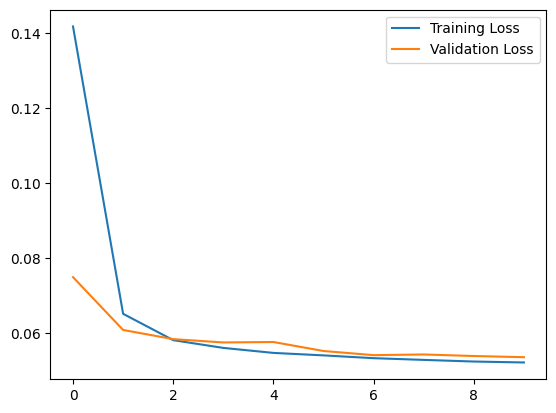

In [14]:
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.legend()
plt.savefig(f"{image_path}{save_prefix}losses.png")
plt.show()

# Testing

Load the model with the lowest validation loss

In [15]:
model = ConvAutoencoderDenoiser(target_size)
model.load_state_dict(torch.load(best_model))

if torch.cuda.is_available():
    model = model.cuda()

## Visualize Results

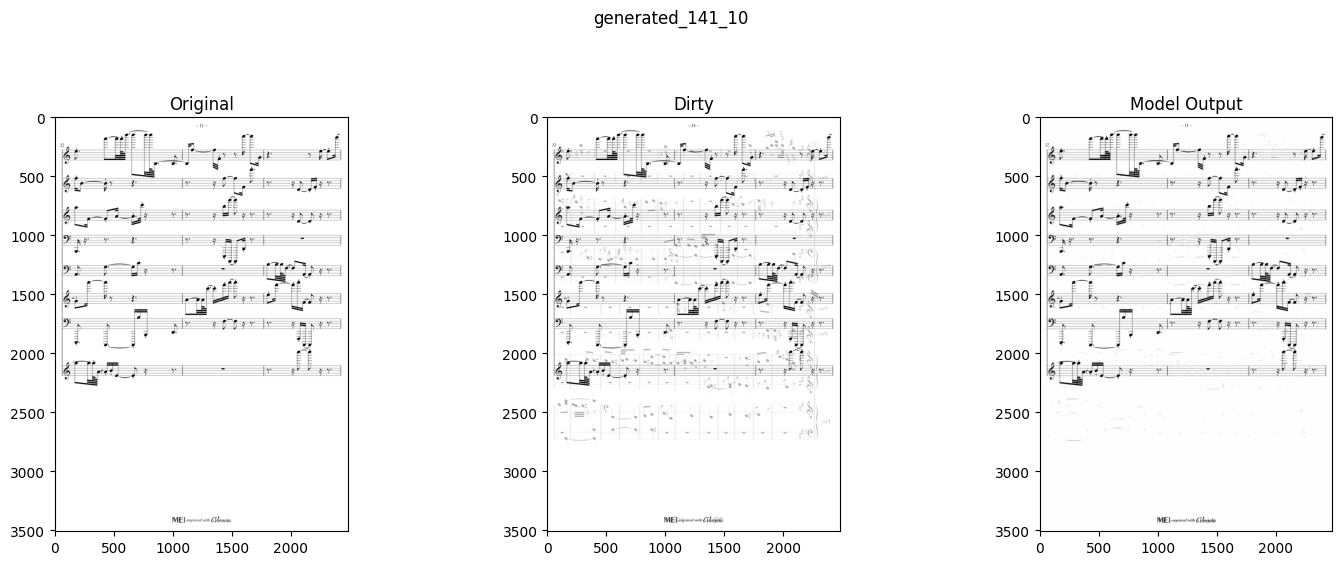

In [16]:
test_filenames = test_dataset[random.randint(0, len(test_dataset) - 1)]
test_images_dirty = preprocess(path_dirty, test_filenames[1], transform_dirty).unsqueeze(0)

if torch.cuda.is_available():
    test_images_dirty = test_images_dirty.cuda()
    
prediction = model(test_images_dirty)

if torch.cuda.is_available():
    prediction = prediction.cpu()
    
prediction_image = undo_preprocessing(prediction)
prediction_image.save(f"{image_path}{save_prefix}output.png")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))
ax1.imshow(Image.open(f"{path_clean}/{test_filenames[0]}"))
ax1.set_title("Original")
ax2.imshow(Image.open(f"{path_dirty}/{test_filenames[1]}"))
ax2.set_title("Dirty")
ax3.imshow(prediction_image)
ax3.set_title("Model Output")

fig.suptitle(test_filenames[0].replace(".png", "")) 
fig.subplots_adjust(top=0.80)
plt.savefig(f"{image_path}{save_prefix}output_comparison.png")
plt.show()

## Evaluate the model on the test set

In [17]:
test_losses = []

with torch.no_grad():
    valid_loss = 0
    
    for i, (filenames_clean, filenames_dirty) in enumerate(test_loader):
        print("\rTest ", round(i/len(valid_loader), 4), end="")    
        try:
            images_clean = torch.stack([preprocess(path_clean, ip, transform_clean) for ip in filenames_clean])
            images_dirty = torch.stack([preprocess(path_dirty, ib, transform_dirty) for ib in filenames_dirty])
        except Exception as e:
            print(f"Problem with {filenames_clean}, {filenames_dirty}: {str(e)}\n\n")
            continue
        
        if torch.cuda.is_available():
            images_dirty, images_clean = images_dirty.cuda(), images_clean.cuda()
            
        outputs = model(images_dirty)
        loss = criterion(outputs, images_clean)
        test_losses.append(loss.item())
    
print(f"\nMean MSE Loss: {sum(test_losses) / len(valid_loader)}")

Test  0.9211
Mean MSE Loss: 0.050279462513955014


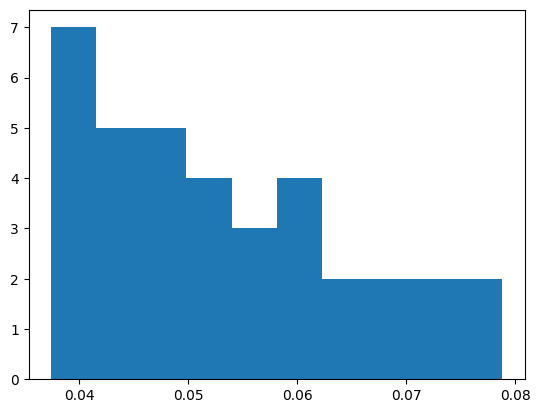

In [18]:
plt.hist(test_losses)
plt.savefig(f"{image_path}{save_prefix}test_losses.png")
plt.show()